In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT_CLASSES_ACCURACY, SAT_CLASSES_SPEED, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# info_path = Path("../data/sat2/preprocessed_500hz/preprocessed_S1_raw.fif")
info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)

In [ ]:
epoched_data_paths = [
    DATA_PATH / 'sat2/data_part1.nc',
    DATA_PATH / 'sat2/data_part2.nc',
]
conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT1_STAGES_ACCURACY, "speed": SAT1_STAGES_SPEED}

cpus = 12

for epoched_data_path in epoched_data_paths:
    epoched_data = xr.load_dataset(epoched_data_path)
    for participant in epoched_data.participant.values:
        epoched_data_participant = epoched_data.sel(participant=[participant])
        print(epoched_data_participant.data.shape)
        print(participant)
        print(epoched_data_participant)
        stage_finder = StageFinder(
            epoched_data_participant,
            labels,
            conditions=conditions,
            cpus=cpus,
            fit_function="fit_single",
            fit_args={"starting_points": 100, "tolerance": 1e-5},
            verbose=False,
            condition_variable="event_name",
            condition_method="contains",
        )
        stage_finder.fit_model()
        stage_finder.visualize_model(positions)
        input("Enter to continue (if model is correct), esc to cancel")
        stage_data = stage_finder.label_model()
        stage_data.to_netcdf(Path("../data/sat2") / (f"stage_data_{participant}.nc"))

In [ ]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz_part1.nc"
output_path = DATA_PATH / "sat2/stage_data_250hz_part1.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

# 5 comps
stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    fits_to_load=["250hz_accuracy_part1.nc", "250hz_speed_part1.nc"]
)
# Retraining model with smaller window
stage_finder.fit_model()

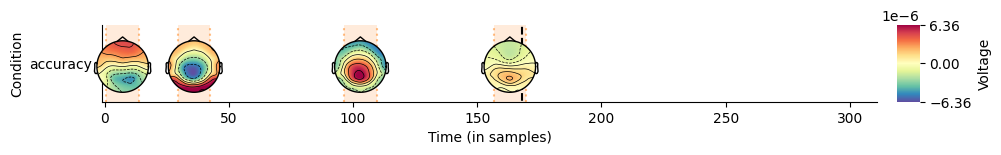

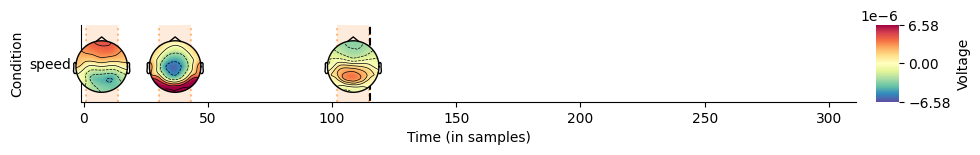

In [4]:
# Visualize model to check if fitting was done as expected

stage_finder.visualize_model(positions)

In [5]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "250hz_accuracy_part1.nc")
hmp.utils.save_fit(stage_finder.fits[1], "250hz_speed_part1.nc")

250hz_accuracy_part1.nc saved
250hz_speed_part1.nc saved


In [4]:
output_path = DATA_PATH / "sat2/stage_data_250hz_part1.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_bump_to_bump__)

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18


In [8]:
'negative' in stage_data.labels.to_numpy().flatten()

False

In [9]:
stage_data.to_netcdf(output_path)

Transforming epoched data to principal component (PC) space


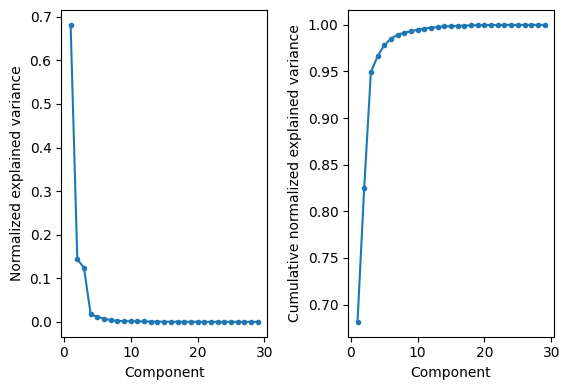

Loading fitted HMP model for accuracy condition
Loading fitted HMP model for speed condition


In [6]:
cpus = 4

epoched_data_path = DATA_PATH / "sat2/data_250hz_part2.nc"
output_path = DATA_PATH / "sat2/stage_data_250hz_part2.nc"

conditions = ["accuracy", "speed"]
labels = {"accuracy": SAT_CLASSES_ACCURACY, "speed": SAT_CLASSES_SPEED}

# 5 comps
stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
    condition_variable="event_name",
    condition_method="contains",
    fits_to_load=["250hz_accuracy_part2.nc", "250hz_speed_part2.nc"]
)
# Retraining model with smaller window
stage_finder.fit_model()

In [7]:
output_path = DATA_PATH / "sat2/stage_data_250hz_part2.nc"
stage_data = stage_finder.label_model(label_fn=stage_finder.__label_bump_to_bump__)

Labeling dataset for accuracy condition
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9


In [120]:

# stage_data = stage_finder.label_model(stage_finder.__label_samples_around_bump__, {"window": (2, 2), "get_negative_class": False})

Labeling dataset for accuracy condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participant S8
Processing participant S9
Labeling dataset for speed condition
Processing participant S1
Processing participant S10
Processing participant S11
Processing participant S12
Processing participant S13
Processing participant S15
Processing participant S16
Processing participant S17
Processing participant S18
Processing participant S2
Processing participant S20
Processing participant S3
Processing participant S4
Processing participant S5
Processing participant S6
Processing participant S7
Processing participan

In [5]:
stage_data.to_netcdf(output_path)

In [ ]:
# Add labels to dataset
stage_data = stage_finder.label_model()

In [6]:
# Save labelled dataset
output_path = Path("../data/sat2/stage_data_part1.nc")
stage_data.to_netcdf(output_path)

In [7]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "../models/100hz_accuracy_sat2.nc")
hmp.utils.save_fit(stage_finder.fits[1], "../models/100hz_speed_sat2.nc")

../models/100hz_accuracy_sat2.nc saved
../models/100hz_speed_sat2.nc saved
